# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from collections import namedtuple
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
import ipywidgets as widgets
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            #("Landshut" in str(x['IB Site Name'])), 
            #("M4" in str(x['Engine ID'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

0   \
Count_OpHour                                        188.0   
OperationalCondition                            Available   
startup_counter                                     138.0   
shutdown_counter                                    138.0   
id                                                 159396   
Engine Version                                        H12   
Engine Type                                           624   
Engine Series                                           6   
Country                                                GB   
Commissioning Date                             2022-01-10   
Design Number                                        AL87   
serialNumber                                      1486144   
Power_PowerNominal                                 4495.0   
Para_Speed_Nominal                                 1500.0   
starts_oph_ratio                                    0.904   
Control System Type                                   XT4   
Engine ID                                             M01   
IB Unit Commissioning Date                     2022-01-10   
IB NOX                                         250 mg/Nm3   
IB Frequency                                           50   
IB Item Description Engine    ENG JMS 624 H312 50__J_AL87   
IB Site Name                               Forsa Hartmoor   
IB Status                          Active Docu incomplete   
Contract.Warranty End Date                     2024-07-10   
Contract.Warranty Start Date                   2022-01-11   
Module_Vers_HalIO                              4.10.2.2.0   
Product Program                                      2020   

                                                       1   \
Count_OpHour                                        185.0   
OperationalCondition                            Available   
startup_counter                                     105.0   
shutdown_counter                                    107.0   
id                                                 159397   
Engine Version                                        H12   
Engine Type                                           624   
Engine Series                                           6   
Country                                                GB   
Commissioning Date                             2022-01-10   
Design Number                                        AL87   
serialNumber                                      1486152   
Power_PowerNominal                                 4495.0   
Para_Speed_Nominal                                 1500.0   
starts_oph_ratio                                    0.777   
Control System Type                                   XT4   
Engine ID                                             M02   
IB Unit Commissioning Date                     2022-01-10   
IB NOX                                         250 mg/Nm3   
IB Frequency                                           50   
IB Item Description Engine    ENG JMS 624 H312 50__J_AL87   
IB Site Name                               Forsa Hartmoor   
IB Status                          Active Docu incomplete   
Contract.Warranty End Date                     2024-07-10   
Contract.Warranty Start Date                   2022-01-11   
Module_Vers_HalIO                              4.10.2.2.0   
Product Program                                      2020   

                                                       2   \
Count_OpHour                                        172.0   
OperationalCondition                            Available   
startup_counter                                     100.0   
shutdown_counter                                    100.0   
id                                                 159399   
Engine Version                                        H12   
Engine Type                                           624   
Engine Series                                           6   
Country                                                GB   
Commissioning Date         

In [4]:
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
display(dl)

Dropdown(description='Engine:', layout=Layout(width='max-content'), options=(('1486144 - Forsa Hartmoor M01', …

In [38]:
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
pd.DataFrame.from_dict(e.dash, orient='index').T

Name Engine ID Design Number Engine Type Engine Version   P  \
0  Forsa Hartmoor M02       M02          AL87         624            H12  24   

    P_nom  BMEP serialNumber      id Count_OpHour  val start oph@start  \
0  4495.0  24.5      1486152  159397        201.0 2022-01-10        54   

  oph parts    LOC  
0     147.0  0.119

In [39]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_days=7) #funktioniert nicht
#fsm = msgFSM(e, p_from=motor['Commissioning Date'], p_to=arrow.now() )
fsm = msgFSM(e, p_from="2022-01-01", p_to=arrow.now(), frompickle=True)
#fsm = msgFSM(e)
fsm.run1(enforce=False) # run Finite State Machine
fsm.store()

FSM: 100%|████████████████████████| 6674/6674 [00:00<00:00, 11491.12 messages/s]


In [40]:
# Struktur zur Aufnahme mehrerer motoren
fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

In [41]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
fsm.summary(res)

In [42]:
pd.DataFrame(fsm._starts)[['index'] +['startpreparation','starter','hochlauf','idle','synchronize','loadramp']].round(2)

index  startpreparation  starter  hochlauf  idle  synchronize  loadramp
0        0             16.33      NaN       NaN   NaN          NaN       NaN
1        1             89.48     3.83     21.39   NaN          NaN       NaN
2        2             16.04      NaN       NaN   NaN          NaN       NaN
3        3            794.53      NaN       NaN   NaN          NaN       NaN
4        4             69.99     4.13     25.12  6.26        55.72     70.88
..     ...               ...      ...       ...   ...          ...       ...
103    103            101.27     4.04     23.71  4.84        48.66     94.52
104    104            102.80     3.93     23.40  4.64         1.51    138.89
105    105            100.13     3.74     23.63  4.44        46.84     96.98
106    106            101.96     3.94     24.62  4.74        60.43     80.96
107    107            103.42     3.64     20.80  4.34        56.87     87.04

[108 rows x 7 columns]

In [43]:
rmodes = ['???','OFF','MANUAL','AUTO']; mw = [] ; modes = []
for mm in rmodes:
    mw.append(widgets.Checkbox(value=False, description='Mode: ' + mm))
display(widgets.VBox(mw))

In [44]:
rsucc = [True,False]; sw = []; success=[]
for rs in rsucc:
    sw.append(widgets.Checkbox(value=False, description='Success: ' + str(rs)))
display(widgets.VBox(sw))

In [45]:
rdf = res['result']
modes = [rmodes[i] for i,v in enumerate(mw) if v.value]
modes = rmodes if not modes else modes
success = [rsucc[i] for i,v in enumerate(sw) if v.value]
success = rsucc if not success else success

rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')
print(modes, success)

['AUTO'] [True]


In [46]:
# special filters can be added like ... 
#rda = rda[((rda['loadramp'] < 80.0) & (rda['startpreparation'] < 300.0))].reset_index(drop='index')

# rda = rda[((rda['count_warnings'] == 0) & (rda['count_alarms'] == 0))].reset_index(drop='index')
# display the filterd & selected data
rda[fsm.filters['filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

success  mode  startpreparation  starter  hochlauf  idle  synchronize  \
0      True  AUTO             69.99     4.13     25.12  6.26        55.72   
1      True  AUTO             60.53     3.84     19.07  5.55        45.95   
2      True  AUTO             60.64     3.63     18.79  5.35        40.35   
3      True  AUTO             60.63     3.83     19.17  5.75        60.33   
4      True  AUTO             63.85     3.63      8.18  6.46        63.66   
..      ...   ...               ...      ...       ...   ...          ...   
64     True  AUTO            101.27     4.04     23.71  4.84        48.66   
65     True  AUTO            102.80     3.93     23.40  4.64         1.51   
66     True  AUTO            100.13     3.74     23.63  4.44        46.84   
67     True  AUTO            101.96     3.94     24.62  4.74        60.43   
68     True  AUTO            103.42     3.64     20.80  4.34        56.87   

    loadramp  cumstarttime targetoperation  count_alarms  count_warnings  
0      70.88        232.10 0 days 00:16:47             0               1  
1     138.89        273.83 0 days 00:00:52             0               0  
2     126.26        255.03 0 days 00:13:21             0               0  
3     126.41        276.12 0 days 00:03:22             0               0  
4     126.00        271.78 0 days 00:12:28             0               2  
..       ...           ...             ...           ...             ...  
64     94.52        277.02 0 days 05:13:31             0               0  
65    138.89        275.18 0 days 03:13:30             0               0  
66     96.98        275.76 0 days 01:43:32             0               0  
67     80.96        276.65 0 days 01:33:30             0               0  
68     87.04        276.11             NaT             0               0  

[69 rows x 12 columns]

In [48]:
rda = fsm.run2(rda)
fsm.store()

FSM Run2: 100%|████████████████████████████| 69/69 [00:28<00:00,  2.43 starts/s]


In [49]:
rdb = rda[(rda['mode'] == 'AUTO') & rda['success'] & (rda['maxload'] > 4000.0)]
rdb[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

index  success  mode  startpreparation  starter  hochlauf  idle  \
2       7     True  AUTO             60.64     3.63     18.79  5.35   
3      10     True  AUTO             60.63     3.83     19.17  5.75   
4      15     True  AUTO             63.85     3.63      8.18  6.46   
5      24     True  AUTO             60.68     3.84     19.48  5.66   
6      28     True  AUTO              0.61     4.94     18.36  4.05   
..    ...      ...   ...               ...      ...       ...   ...   
63    102     True  AUTO            102.09     3.74     19.69  4.45   
64    103     True  AUTO            101.27     4.04     23.71  4.84   
65    104     True  AUTO            102.80     3.93     23.40  4.64   
66    105     True  AUTO            100.13     3.74     23.63  4.44   
67    106     True  AUTO            101.96     3.94     24.62  4.74   

    synchronize  loadramp  cumstarttime  maxload  ramprate targetoperation  \
2         40.35    128.01        256.77  4489.75      0.78 0 days 00:13:21   
3         60.33    127.37        277.09  4490.61      0.78 0 days 00:03:22   
4         63.66    127.49        273.28  4496.30      0.78 0 days 00:12:28   
5         56.82    128.38        274.85  4507.37      0.78 0 days 00:07:07   
6          0.80    206.09        234.85  4445.32      0.48 0 days 00:05:00   
..          ...       ...           ...      ...       ...             ...   
63        65.49     83.82        279.27  4518.00      1.20 0 days 04:13:30   
64        48.66     98.35        280.86  4588.47      1.04 0 days 05:13:31   
65         1.51    143.34        279.62  4564.10      0.71 0 days 03:13:30   
66        46.84     98.79        277.57  4524.65      1.02 0 days 01:43:32   
67        60.43     84.99        280.68  4609.95      1.21 0 days 01:33:30   

    count_alarms  count_warnings  
2            0.0             0.0  
3            0.0             0.0  
4            0.0             2.0  
5            0.0             1.0  
6            0.0             1.0  
..           ...             ...  
63           0.0             0.0  
64           0.0             0.0  
65           0.0             0.0  
66           0.0             0.0  
67           0.0             0.0  

[65 rows x 15 columns]

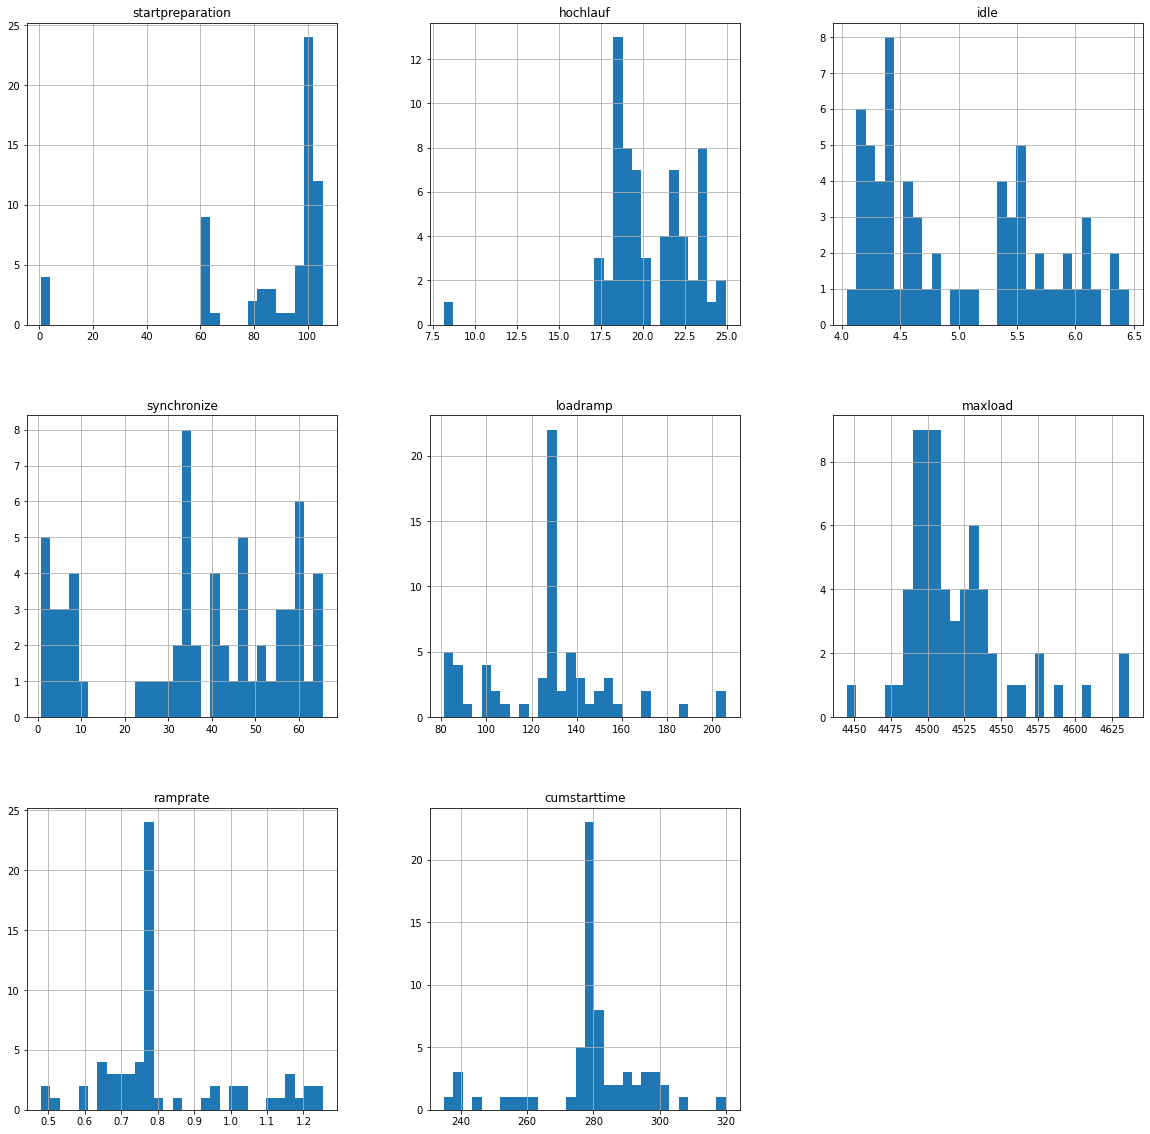

In [50]:
rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime']].hist(bins=30,figsize=(20,20));

In [53]:
rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime']].describe().round(2)

startpreparation  hochlauf   idle  synchronize  loadramp  maxload  \
count             65.00     65.00  65.00        65.00     65.00    65.00   
mean              86.35     20.35   4.99        36.33    127.47  4518.14   
std               26.56      2.59   0.72        20.83     27.19    34.97   
min                0.60      8.18   4.05         0.80     81.24  4445.32   
25%               83.13     18.66   4.44        24.11    107.81  4497.00   
50%               99.09     19.79   4.74        40.35    128.60  4507.00   
75%              101.96     22.19   5.55        55.94    137.86  4530.43   
max              105.70     24.94   6.46        65.49    206.09  4636.51   

       ramprate  cumstarttime  
count     65.00         65.00  
mean       0.83        279.47  
std        0.19         16.05  
min        0.48        234.85  
25%        0.73        277.67  
50%        0.78        279.72  
75%        0.93        286.11  
max        1.25        320.00

In [54]:
startversuch = rda.iloc[65];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())

vset = fsm._data_spec + ['Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_TempOil']

ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von: {von_dt.strftime('%d.%m.%Y %H:%M:%S')} = {von} bis: {bis_dt} = {bis}")
data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)

von: 21.02.2022 17:15:06 = 1645463706 bis: 2022-02-21 20:33:11.904999936 = 1645475591


Load Data: 20000 datarows [00:01, 13148.76 datarows/s]                          


In [55]:
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_TempOil'],'_ylim': [60, 110], 'color':'#2171b5'}
]
fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(18,10), style='line', line_width=0)

sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_dbokeh_lines(start,lines,fig,line_color='red', line_dash='solid', line_alpha=0.4)

bokeh.plotting.show(fig)

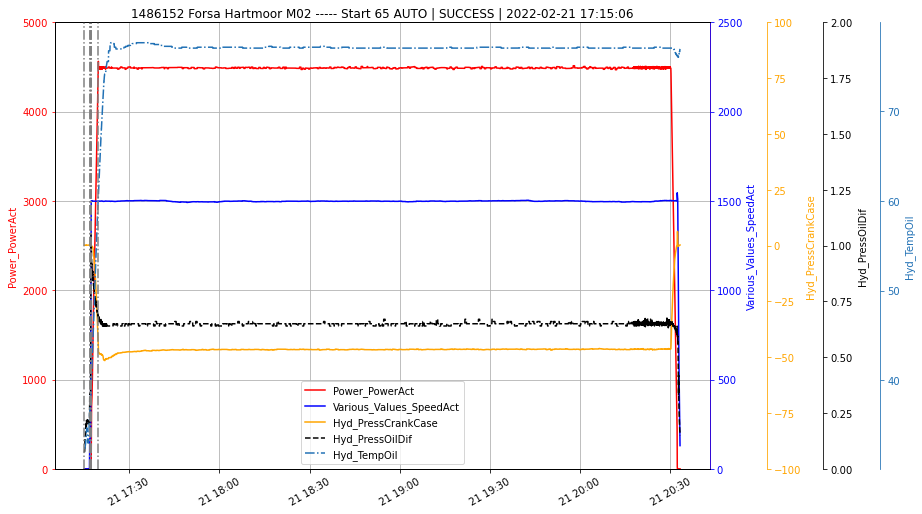

In [56]:
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_lines(start, lines, ax, color='gray', linestyle="-.")

In [57]:
dset = [
    {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,10000)}
]
pl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
pr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
dmyplant2.add_dbokeh_lines(pl.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_lines(pr.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
bokeh.plotting.show(fig)

In [58]:
dset = [
    {'col':['Power_PowerAct','Power_PowerAct_left','Power_PowerAct_right'], 'ylim':(0,40000)}
]
pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
dmyplant2.add_dbokeh_lines(pl.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_lines(pr.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
bokeh.plotting.show(fig)


In [59]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], 'ylim':(0,30000)},
    {'col':['Power_PowerAct_left','Power_PowerAct_right','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,30000)}
    ]

pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
#fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
summary = pd.DataFrame(startversuch[fsm.filters['filter_times']], dtype=np.float64).round(2).T
display(HTML('<h3>'+ summary.to_html(escape=False, index=False) + '</h3>'))

fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)

sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_dbokeh_lines(start, lines, fig,line_color='red', line_dash='solid', line_alpha=0.4)

dmyplant2.add_dbokeh_lines(sl.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_lines(sr.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_lines(pl.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_lines(pr.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
bokeh.plotting.show(fig)


In [60]:
# dset = [
#     {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,10000)}
# ]
dset = [
    {'col':['Power_PowerAct'], '_ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'_ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'_ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'_ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_TempOil'],'_ylim': [60, 110], 'color':'#2171b5'}
]
for ii,startversuch in rda.iterrows():
        if ii < 0:
                continue
        if ii > 10:
                break
        data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1, p_data=fsm._data_spec + ['Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_TempOil'])

        pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
        pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
        sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
        sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')

        ftitle = f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"

        fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(16,10), style='line', line_width=0)

        ml = (data.iloc[-1]['time'] - data.iloc[0]['time']) // 1000
        sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']]]
        start = startversuch['starttime']; 
        #lines=list(np.cumsum(sv_lines))
        nsv_lines = [v for v in sv_lines if ((v==v) and (v <= ml)) ]
        lines=list(np.cumsum(nsv_lines))
        dmyplant2.add_dbokeh_lines(start, lines, fig,line_color='red', line_dash='solid', line_alpha=0.4)

        dmyplant2.add_dbokeh_lines(sl.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
        dmyplant2.add_dbokeh_lines(sr.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
        dmyplant2.add_dbokeh_lines(pl.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
        dmyplant2.add_dbokeh_lines(pr.loc, [], fig,line_color='red', line_dash='solid', line_alpha=0.4)
        bokeh.plotting.show(fig) 
                
        svdf = pd.DataFrame(sv_lines, index=fsm.filters['vertical_lines_times'], columns=['FSM']).fillna(0)
        svdf['RUN2'] = svdf['FSM']
        #if svdf.at['hochlauf','FSM'] > 0.0:
        #        svdf.at['hochlauf','RUN2'] = sl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['starter']
        #        svdf.at['idle','RUN2'] = svdf.at['idle','FSM'] - (svdf.at['hochlauf','RUN2'] - svdf.at['hochlauf','FSM'])
        if svdf.at['loadramp','FSM'] > 0.0:
                svdf.at['loadramp','RUN2'] = pl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['synchronize']
        with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                svdf = pd.concat([
                        svdf, 
                        pd.DataFrame.from_dict(
                                {       'maxload':['-',pl.val],
                                        'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],
                                        'cumstarttime':[np.cumsum(svdf['FSM'])['loadramp'], np.cumsum(svdf['RUN2'])['loadramp']]
                                }, 
                                columns=['FSM','RUN2'],
                                orient='index')]
                        )
        summary = pd.DataFrame(startversuch[fsm.filters['filter_times']], dtype=np.float64).round(2).T
        display(HTML('<h3>'+ summary.to_html(escape=False, index=False) + '</h3>'))

        for i, al in enumerate(startversuch['alarms']):
                print(f"{al['state']:16} {fsm.msgtxt(al['msg'],i)}")

        for i, w in enumerate(startversuch['warnings']):
                print(f"{w['state']:16} {fsm.msgtxt(w['msg'],i)}")

        plt.show();

Load Data: 20000 datarows [00:00, 53288.58 datarows/s]                          


targetoperation  000000 700 1641493475761 06.01.2022 18:24:35  2531 Charge temperature before high-pressure turbocharger minimum


Load Data: 20000 datarows [00:00, 92791.98 datarows/s]                          


Load Data: 20000 datarows [00:00, 89018.72 datarows/s]                          


Load Data: 20000 datarows [00:00, 51397.10 datarows/s]                          


Load Data: 20000 datarows [00:00, 59804.87 datarows/s]                          


synchronize      000000 700 1641759202507 09.01.2022 20:13:22  9304 Deviation in switch-on time for generator switch
targetoperation  000001 700 1641759721382 09.01.2022 20:22:01  3160 Gas volume measuring signal failure


Load Data: 20000 datarows [00:00, 61926.96 datarows/s]                          


loadramp         000000 700 1641814380720 10.01.2022 11:33:00  9304 Deviation in switch-on time for generator switch


Load Data: 20000 datarows [00:00, 93208.72 datarows/s]                          


loadramp         000000 700 1641816402917 10.01.2022 12:06:42  2688 Generator current at synchronization too high


Load Data: 20000 datarows [00:00, 91905.07 datarows/s]                          


Load Data: 20000 datarows [00:00, 94254.76 datarows/s]                          


loadramp         000000 700 1641817922029 10.01.2022 12:32:02  9304 Deviation in switch-on time for generator switch


Load Data: 20000 datarows [00:00, 83567.35 datarows/s]                          


Load Data: 20000 datarows [00:01, 17652.86 datarows/s]                          


targetoperation  000000 700 1641844739790 10.01.2022 19:58:59  3160 Gas volume measuring signal failure


In [61]:
rda.describe().round(1).T

count                       mean                        std  \
index             69.0                       59.3                       27.0   
cumstarttime      69.0                      276.8                       20.2   
startpreparation  69.0                       86.8                       26.9   
starter           69.0                        4.0                        0.3   
hochlauf          69.0                       20.4                        2.6   
idle              69.0                        5.0                        0.7   
synchronize       69.0                       36.6                       20.8   
loadramp          69.0                      124.0                       30.2   
targetoperation     68  0 days 01:46:45.338235294  0 days 01:58:37.732742338   
maxload           68.0                     4424.7                      443.8   
ramprate          68.0                        0.8                        0.2   
count_alarms      68.0                        0.0                        0.0   
count_warnings    68.0                        0.4                        0.6   

                              min              25%              50%  \
index                         4.0             40.0             59.0   
cumstarttime                200.7            277.1            279.6   
startpreparation              0.6             80.1             99.1   
starter                       3.4              3.7              3.9   
hochlauf                      8.2             18.7             19.8   
idle                          4.0              4.3              4.7   
synchronize                   0.8             24.1             40.9   
loadramp                     43.5            101.1            128.4   
targetoperation   0 days 00:00:52  0 days 00:24:01  0 days 00:53:54   
maxload                    2017.5           4492.7           4504.3   
ramprate                      0.5              0.7              0.8   
count_alarms                  0.0              0.0              0.0   
count_warnings                0.0              0.0              0.0   

                                     75%              max  
index                               78.0            107.0  
cumstarttime                       285.8            320.0  
startpreparation                   102.1            141.3  
starter                              4.1              4.9  
hochlauf                            22.2             25.1  
idle                                 5.6              6.5  
synchronize                         55.9             65.5  
loadramp                           136.7            206.1  
targetoperation   0 days 03:03:31.250000  0 days 10:28:01  
maxload                           4530.4           4636.5  
ramprate                             0.9              1.3  
count_alarms                         0.0              0.0  
count_warnings                       1.0              2.0

In [62]:
longer_than_300s = rda[fsm.filters['filter_period'] + fsm.filters['filter_content']][rda['cumstarttime'] > 300.0]
longer_than_300s[fsm.filters['filter_content']].round(2)

success  mode  startpreparation  starter  hochlauf  idle  synchronize  \
10     True  AUTO             99.09     4.05     20.21  5.85        50.66   
11     True  AUTO            102.08     3.74     22.67  6.16        58.66   
19     True  AUTO            101.16     3.84     21.10  5.95        33.19   
55     True  AUTO             61.65     4.24     17.15  4.34         9.18   

    loadramp  cumstarttime targetoperation  
10    128.75        308.62 0 days 03:05:26  
11    126.69        320.00 0 days 00:04:12  
19    136.68        301.90 0 days 03:00:15  
55    205.62        302.18 0 days 00:24:11

In [63]:
longer_than_300s.describe().round(2).T

count             mean                        std  \
startpreparation   4.0             91.0                      19.61   
starter            4.0             3.96                       0.22   
hochlauf           4.0            20.28                       2.32   
idle               4.0             5.57                       0.83   
synchronize        4.0            37.92                      21.92   
loadramp           4.0           149.44                      37.71   
cumstarttime       4.0           308.18                       8.47   
targetoperation      4  0 days 01:38:31  0 days 01:37:44.052125734   

                              min                     25%              50%  \
startpreparation            61.65                   89.73           100.13   
starter                      3.74                    3.81             3.94   
hochlauf                    17.15                   19.44            20.65   
idle                         4.34                    5.48              5.9   
synchronize                  9.18                   27.18            41.92   
loadramp                   126.69                  128.23           132.72   
cumstarttime                301.9                  302.11            305.4   
targetoperation   0 days 00:04:12  0 days 00:19:11.250000  0 days 01:42:13   

                                     75%              max  
startpreparation                  101.39           102.08  
starter                             4.09             4.24  
hochlauf                           21.49            22.67  
idle                                 6.0             6.16  
synchronize                        52.66            58.66  
loadramp                          153.92           205.62  
cumstarttime                      311.46            320.0  
targetoperation   0 days 03:01:32.750000  0 days 03:05:26

In [64]:
load_ramp_less_than_100s = rdb[fsm.filters['filter_period'] + fsm.filters['run2filter_content']][(rdb['loadramp'] < 100.0) & (rdb['maxload'] > 4000.0)]
lfsm = load_ramp_less_than_100s[['starttime']+fsm.filters['run2filter_content']]
lfsm = lfsm.sort_values(by = "index",ascending=True).reset_index(drop='index').round(2)
lfsm

starttime  index  success  mode  startpreparation  \
0  2022-01-20 08:55:02.668000000     59     True  AUTO            102.12   
1  2022-01-21 09:55:02.278000128     62     True  AUTO            100.89   
2  2022-01-22 16:55:03.240000000     63     True  AUTO            102.60   
3  2022-01-23 11:55:03.355000064     64     True  AUTO            103.96   
4  2022-01-23 17:10:03.924999936     65     True  AUTO            101.78   
5  2022-01-24 09:25:06.228000000     66     True  AUTO            102.41   
6  2022-01-25 06:55:04.417999872     68     True  AUTO            100.35   
7  2022-01-26 07:25:05.107000064     73     True  AUTO            102.87   
8  2022-02-18 15:05:05.569999872    100     True  AUTO            101.69   
9  2022-02-19 15:15:05.735000064    102     True  AUTO            102.09   
10 2022-02-20 16:15:08.144000000    103     True  AUTO            101.27   
11 2022-02-22 17:45:07.432999936    105     True  AUTO            100.13   
12 2022-02-24 08:55:07.320000000    106     True  AUTO            101.96   

    starter  hochlauf  idle  synchronize  loadramp  cumstarttime  maxload  \
0      3.63     22.70  4.44        63.97     82.48        279.33  4542.00   
1      4.14     21.31  4.44        57.61     91.34        279.72  4554.13   
2      4.14     23.40  4.54        61.46     83.63        279.76  4636.51   
3      4.23     22.09  4.44        63.68     81.24        279.64  4576.18   
4      4.03     19.79  4.26        59.99     88.22        278.08  4501.00   
5      4.34     21.79  4.54        60.72     85.97        279.77  4521.07   
6      3.74     21.61  4.34        61.04     89.51        280.58  4634.58   
7      3.73     21.93  4.45        58.29     87.63        278.89  4537.01   
8      3.94     23.53  5.15        55.94     99.19        289.43  4576.00   
9      3.74     19.69  4.45        65.49     83.82        279.27  4518.00   
10     4.04     23.71  4.84        48.66     98.35        280.86  4588.47   
11     3.74     23.63  4.44        46.84     98.79        277.57  4524.65   
12     3.94     24.62  4.74        60.43     84.99        280.68  4609.95   

    ramprate targetoperation  
0       1.23 0 days 03:03:32  
1       1.11 0 days 00:33:28  
2       1.23 0 days 01:33:30  
3       1.25 0 days 00:33:28  
4       1.14 0 days 00:48:32  
5       1.17 0 days 04:54:39  
6       1.15 0 days 02:18:27  
7       1.15 0 days 01:03:28  
8       1.03 0 days 04:53:33  
9       1.20 0 days 04:13:30  
10      1.04 0 days 05:13:31  
11      1.02 0 days 01:43:32  
12      1.21 0 days 01:33:30

In [66]:
rdc = rdb[rdb.starttime > '2022-01-01']
dset = [
    {'col':['ramprate'],'ylim':(-1,3)},
    {'col':['cumstarttime'],'ylim':(0,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(0,400)},
    {'col':['startpreparation'],'ylim':(-100,200)},
    {'col':['hochlauf'],'ylim':(0,100), 'color':'black'},
    {'col':['maxload'],'ylim':(500,5500) }
]
ftitle = f"{fsm._e}"
fig = dmyplant2.dbokeh_chart(rdc, dset, x='starttime', figsize=(16,10) ,title=ftitle);
bokeh.plotting.show(fig)

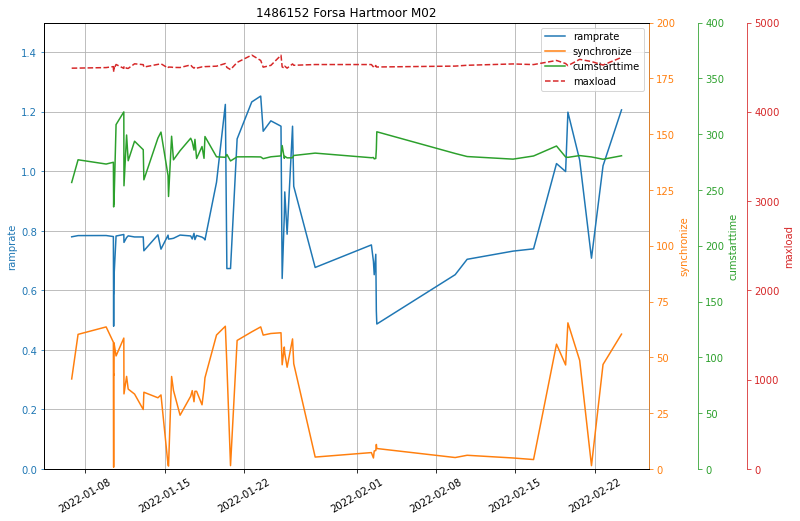

In [67]:
dset = [
    {'col':['ramprate'],'ylim':(0,1.5)},
    {'col':['synchronize'],'ylim':(0,200)},
    {'col':['cumstarttime'],'ylim':(0,400)},
    {'col':['maxload'],'ylim':(0,5000) }
]
dmyplant2.chart(rdb, dset, x='starttime', figsize=(12,8), title=ftitle);

In [68]:
rda.reset_index(drop='index').iloc[10];

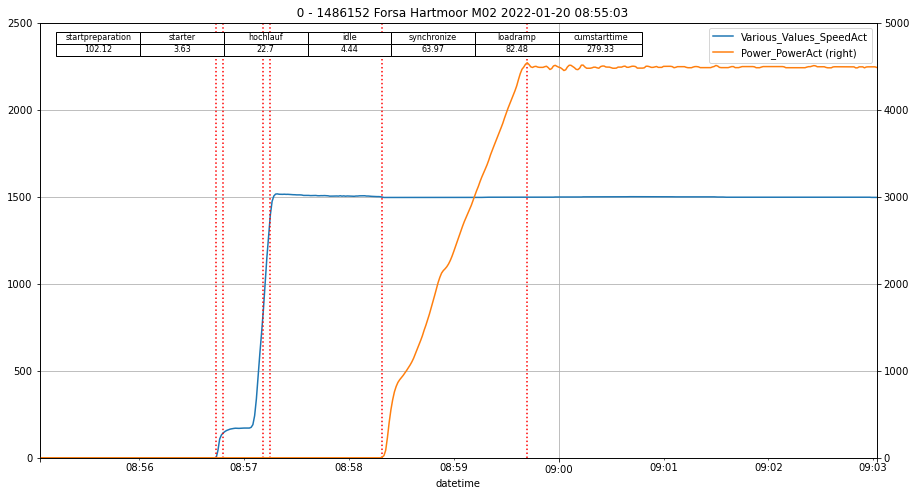

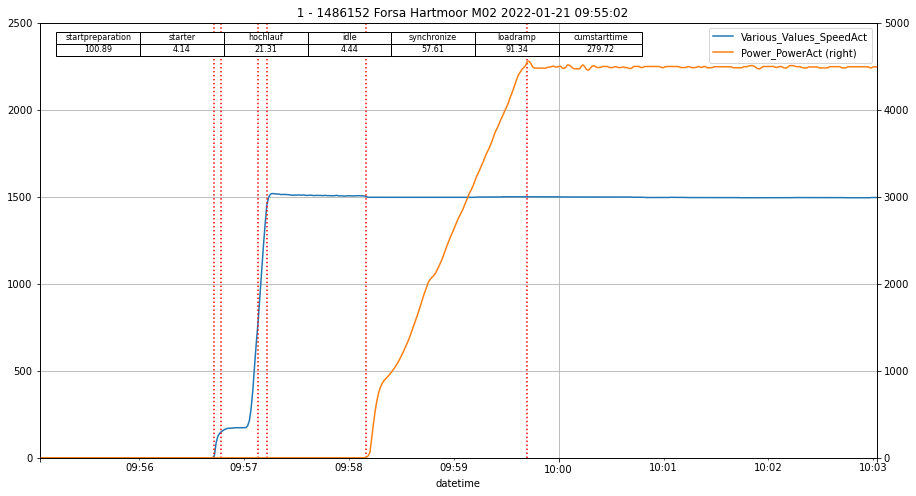

In [69]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    if i >= 2:
        break
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(15,8), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 100
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
fsm._target_load_message

In [ ]:
#fsm.store()